# ELBO for DDPM — Theory, Derivation, and Intuition

## 0. Short Summary
Denoising Diffusion Probabilistic Models (DDPM) define:
- a fixed forward noising (diffusion) chain $q(x_{1:T}\mid x_0)$ that gradually adds Gaussian noise, and
- a learned reverse chain $p_\theta(x_{0:T})$ approximating $q$ in reverse.

Training is done by maximizing the log-likelihood $\log p_\theta(x_0)$ — typically optimized via a variational lower bound (ELBO). The ELBO decomposes into per-timestep KL terms and a reconstruction term.

---

## 1. Notation
- $x_0$ — data sample (image).  
- $t\in\{1,\dots,T\}$ — discrete time index.  
- $\beta_t\in(0,1)$ — noise schedule.  
- $\alpha_t = 1 - \beta_t,\quad \bar\alpha_t = \prod_{s=1}^t \alpha_s$.  
- Forward transition:
  $$
  q(x_t\mid x_{t-1}) = \mathcal{N}\big(x_t;\sqrt{1-\beta_t}\,x_{t-1}, \beta_t I\big).
  $$
- Closed-form forward:
  $$
  q(x_t\mid x_0) = \mathcal{N}\big(x_t; \sqrt{\bar\alpha_t}\,x_0,\; (1-\bar\alpha_t)I\big).
  $$

---

## 2. Reverse model & objective
We approximate the intractable reverse chain $q(x_{t-1}\mid x_t)$ with a learned Gaussian:
$$
p_\theta(x_{t-1}\mid x_t) = \mathcal{N}\big(x_{t-1};\mu_\theta(x_t,t),\Sigma_\theta(x_t,t)\big).
$$

The marginal log-likelihood $\log p_\theta(x_0)$ is lower-bounded by the ELBO:
$$
\log p_\theta(x_0) \ge -L_{\mathrm{ELBO}}(x_0)
$$
with
$$
L_{\mathrm{ELBO}} = \underbrace{D_{KL}\big(q(x_T\mid x_0)\,\|\,p(x_T)\big)}_{(A)}
+ \sum_{t=2}^T \underbrace{ \mathbb{E}_{q(x_t\mid x_0)}\big[ D_{KL}\big(q(x_{t-1}\mid x_t, x_0)\,\|\,p_\theta(x_{t-1}\mid x_t)\big) \big] }_{(B_t)}
- \underbrace{\mathbb{E}_{q(x_1\mid x_0)}\big[\log p_\theta(x_0\mid x_1)\big]}_{(C)}.
$$

Interpretation:
- $(A)$: mismatch between noised data at $T$ and the prior $p(x_T)$ (usually small if both Gaussian).  
- $(B_t)$: KL between true reverse posterior $q(x_{t-1}\mid x_t,x_0)$ and model reverse $p_\theta$. These are the main training terms.  
- $(C)$: final reconstruction likelihood term.

---

## 3. Closed forms & simplifications

### 3.1 Posterior $q(x_{t-1}\mid x_t,x_0)$
Because all transitions are Gaussian, the posterior is Gaussian with analytically computable mean and variance:
$$
q(x_{t-1}\mid x_t, x_0) = \mathcal{N}\big(x_{t-1};\tilde{\mu}(x_t, x_0), \tilde{\beta}_t I\big),
$$
where
$$
\tilde{\mu}(x_t, x_0) = \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t} x_0 + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} x_t,
\quad
\tilde{\beta}_t = \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t}\beta_t.
$$

(Exact algebra can be derived by completing the square.)

### 3.2 Parameterization via predicted noise
Rather than predicting $\mu_\theta$ directly, it is helpful to predict the noise $\epsilon$ used in the forward process:
- If a model outputs $\hat\epsilon_\theta(x_t,t)$, we can compute
$$
\hat\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}
\Big(x_t - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}} \hat\epsilon_\theta(x_t,t)\Big).
$$

Ho et al. show that minimizing the simplified $L_{\mathrm{simple}}$:
$$
L_{\mathrm{simple}}(\theta) = \mathbb{E}_{x_0,\epsilon,t}\big[ \| \epsilon - \hat\epsilon_\theta(x_t,t) \|^2 \big]
$$
is equivalent (up to weighting) to minimizing the ELBO terms $(B_t)$ in practice (with some manipulations and choice of fixed variances).

---

## 4. Practical training steps (conceptual)
1. Sample $x_0\sim$ data, $t\sim \mathrm{Uniform}\{1,\dots,T\}$, and $\epsilon\sim \mathcal{N}(0,I)$.  
2. Construct $x_t = \sqrt{\bar\alpha_t}\,x_0 + \sqrt{1-\bar\alpha_t}\,\epsilon$.  
3. Predict $\hat\epsilon_\theta(x_t,t)$.  
4. Compute loss $\|\epsilon - \hat\epsilon_\theta\|^2$ (optionally weighted by schedule-dependent factors).  
5. Backpropagate & update $\theta$.

---

## 5. Intuitions & visuals you will see in the notebook
- **Forward noising**: images progressively destroyed as $t$ increases.  
- **ELBO decomposition**: how per-timestep KL / reconstruction terms sum to the total.  
- **Noise-prediction loss**: MSE that the network learns.  
- **2D & 3D plots**: ELBO (or its proxy MSE) vs timestep, and a 3D surface showing how loss depends on $t$ and a parameter (e.g., scale of $\beta$).

---

## 6. End notes
- The full ELBO is exact but in practice we optimize the simpler noise-prediction loss because it is numerically stable and works well.  
- If you want the step-by-step algebra for deriving $q(x_{t-1}\mid x_t,x_0)$ and the explicit formula for $\tilde{\mu}$ and $\tilde{\beta}_t$, tell me and I'll paste the completed-square algebra as another markdown block.


In [1]:
# Cell A — imports & config
import os, math, numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = {
    "img_size": 28,
    "T": 100,                # small T for demo; increase for real experiments
    "beta_start": 1e-4,
    "beta_end": 2e-2,
    "seed_img_idx": 0,       # index of seed image to visualize
}
os.makedirs("ddpm_demo_outputs", exist_ok=True)
print("Device:", device, "T:", config["T"])


Device: cuda T: 100


In [2]:
# Cell B — beta schedule and helper functions (and prints)
T = config["T"]
betas = np.linspace(config["beta_start"], config["beta_end"], T).astype(np.float64)
alphas = 1.0 - betas
alpha_bar = np.cumprod(alphas)

def q_sample_x_t(x0, t, eps=None):
    """
    Sample x_t from q(x_t | x0) using closed form:
    x_t = sqrt(alpha_bar[t]) * x0 + sqrt(1-alpha_bar[t]) * eps
    t is 0..T-1 indexing here but conceptually t in 1..T
    """
    if eps is None:
        eps = np.random.randn(*x0.shape).astype(np.float32)
    sqrt_ab = math.sqrt(alpha_bar[t])
    sqrt_1_ab = math.sqrt(1.0 - alpha_bar[t])
    return sqrt_ab * x0 + sqrt_1_ab * eps, eps

print("First 5 betas:", betas[:5])
print("alpha_bar[t=0..4]:", alpha_bar[:5])


First 5 betas: [0.0001     0.00030101 0.00050202 0.00070303 0.00090404]
alpha_bar[t=0..4]: [0.9999     0.99959902 0.9990972  0.99839481 0.99749222]


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.77MB/s]


Seed image index: 0 label: 7 x0 shape: (28, 28)


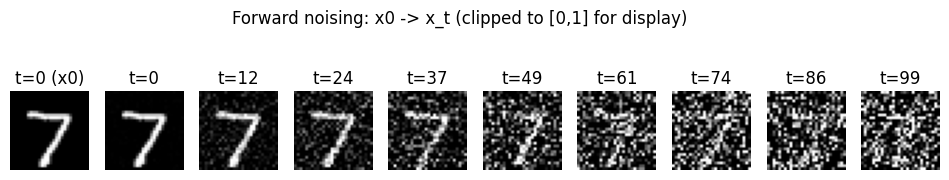

In [3]:
# Cell C — load MNIST and visualize forward noising at selected timesteps
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=1, shuffle=False)
x0, y0 = mnist[config["seed_img_idx"]]
x0_np = x0.numpy().squeeze()  # shape (28,28)
print("Seed image index:", config["seed_img_idx"], "label:", y0, "x0 shape:", x0_np.shape)

# choose timesteps to visualize
ts = np.linspace(0, T-1, 9, dtype=int)
fig, axes = plt.subplots(1, len(ts)+1, figsize=(12,2.5))
axes[0].imshow(x0_np, cmap='gray'); axes[0].set_title("t=0 (x0)"); axes[0].axis('off')
for i, t in enumerate(ts):
    x_t, eps = q_sample_x_t(x0_np, t)
    axes[i+1].imshow(np.clip(x_t, 0, 1), cmap='gray')
    axes[i+1].set_title(f"t={t}")
    axes[i+1].axis('off')
plt.suptitle("Forward noising: x0 -> x_t (clipped to [0,1] for display)")
plt.show()


In [5]:
# Cell D — Compute ELBO components (A), (B_t), (C) analytically where possible.
# We compute:
# (A) KL(q(x_T|x0) || p(x_T))
# (B_t) KL(q(x_{t-1}|x_t,x0) || p_theta(x_{t-1}|x_t))
# (C) Approx reconstruction term using MSE proxy

import numpy as np
import math
import scipy.stats as stats

# --------------------------------------
# (A) KL: q(x_T|x0) vs p(x_T)=N(0,I)
# --------------------------------------

# q(x_T|x0) = N( sqrt(alpha_bar[T-1]) * x0 , (1 - alpha_bar[T-1]) * I )
var_T = 1.0 - alpha_bar[-1]
mean_T = math.sqrt(alpha_bar[-1]) * x0_np

# KL for diagonal Gaussians:
# D = 0.5 * [ (var_T - 1)*n + ||mean_T||^2 + n * log(1/var_T) ]
n_pixels = x0_np.size

kl_A = 0.5 * (
    (var_T - 1.0) * n_pixels
    + np.sum(mean_T**2)
    + n_pixels * math.log(1.0 / var_T)
)
print(f"(A) KL q(x_T|x0) || N(0,I)  = {kl_A:.4f} (total over pixels)")


# --------------------------------------------------------------
# (B_t) KL between q(x_{t-1}|x_t,x0) and a toy model p_theta
# --------------------------------------------------------------

def posterior_q_xt1_given_xt_x0_params(x_t, x0, t):
    """Return mean and variance of posterior q(x_{t-1}|x_t, x0)."""

    a_t = alphas[t]
    a_t_1 = alphas[t-1] if t - 1 >= 0 else 1.0

    ab_t = alpha_bar[t]
    ab_t_1 = alpha_bar[t-1] if t - 1 >= 0 else 1.0

    # closed-form posterior parameters
    c1 = math.sqrt(ab_t_1) * betas[t] / (1.0 - ab_t)
    c2 = math.sqrt(a_t) * (1.0 - ab_t_1) / (1.0 - ab_t)
    var = (1.0 - ab_t_1) * betas[t] / (1.0 - ab_t)

    mean = c1 * x0 + c2 * x_t
    return mean, var


# Compute B_t for t=1..20
tsample = list(range(1, min(20, T)))
B_ideal = []
B_naive = []

for t in tsample:

    # Sample x_t using closed-form forward process
    x_t, eps = q_sample_x_t(x0_np, t)

    # posterior q mean/variance
    mean_q, var_q = posterior_q_xt1_given_xt_x0_params(x_t, x0_np, t)

    # Ideal p_theta = q → KL = 0
    B_ideal.append(0.0)

    # Naive: mean = sqrt(alpha_bar[t-1]) / sqrt(alpha_bar[t]) * x_t
    if t - 1 >= 0:
        mu_naive = math.sqrt(alpha_bar[t-1]) * x_t / math.sqrt(alpha_bar[t])
    else:
        mu_naive = np.zeros_like(x_t)

    # naive variance: 1.5 × true variance
    var_naive = var_q * 1.5

    # KL for each pixel: KL(N(mean_q,var_q)||N(mu_naive,var_naive))
    kl_per_pixel = 0.5 * (
        (var_q / var_naive)
        - 1.0
        + ((mean_q - mu_naive) ** 2) / var_naive
        + np.log(var_naive / var_q)
    )

    B_naive.append(np.sum(kl_per_pixel))

# Show first 8 timesteps
for i, t in enumerate(tsample[:8]):
    print(f"t={t:2d} | B_ideal={B_ideal[i]:8.3f} | B_naive={B_naive[i]:8.3f}")


# -------------------------------------------------------------
# (C) Approximate reconstruction term using simple MSE proxy
# -------------------------------------------------------------

# sample x1 ~ q(x1 | x0)
x1, e1 = q_sample_x_t(x0_np, 1)

# naive reconstruction: undo diffusion at t=1
x0_hat = x1 / math.sqrt(alpha_bar[1])

# FIXED: Using NumPy (x0_np is NumPy, x0_hat is NumPy)
mse_proxy = np.mean((x0_np - x0_hat) ** 2) * n_pixels

print(f"(C) proxy reconstruction MSE sum over pixels = {mse_proxy:.4f}")


(A) KL q(x_T|x0) || N(0,I)  = 45.3721 (total over pixels)
t= 1 | B_ideal=   0.000 | B_naive= 837.055
t= 2 | B_ideal=   0.000 | B_naive= 337.886
t= 3 | B_ideal=   0.000 | B_naive= 222.045
t= 4 | B_ideal=   0.000 | B_naive= 177.756
t= 5 | B_ideal=   0.000 | B_naive= 137.533
t= 6 | B_ideal=   0.000 | B_naive= 132.111
t= 7 | B_ideal=   0.000 | B_naive= 104.851
t= 8 | B_ideal=   0.000 | B_naive= 100.636
(C) proxy reconstruction MSE sum over pixels = 0.3268


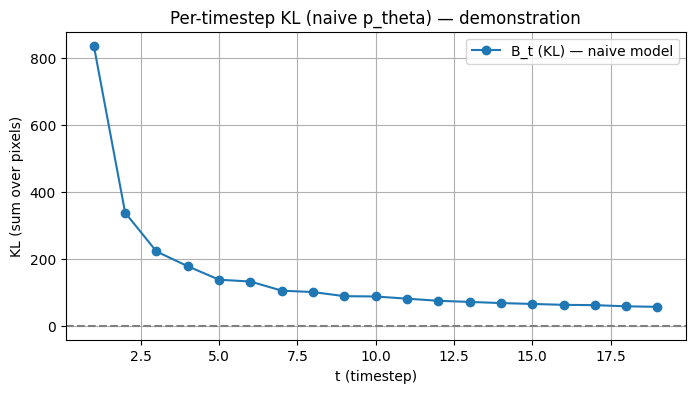

Interpretation (printed):
 - B_t (KL) measures how far a chosen p_theta is from the true posterior q(x_{t-1}|x_t,x0).
 - Ideally B_t -> 0 if model is perfect (we plotted B_ideal=0).
 - In practice we train a network to reduce these B_t terms (via noise prediction).


In [6]:
# Cell E — Plot per-timestep B_naive and the MSE proxy to visualize how ELBO components vary with t
ts = tsample
plt.figure(figsize=(8,4))
plt.plot(ts, B_naive, marker='o', label='B_t (KL) — naive model')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('t (timestep)')
plt.ylabel('KL (sum over pixels)')
plt.title('Per-timestep KL (naive p_theta) — demonstration')
plt.legend()
plt.grid(True)
plt.show()

print("Interpretation (printed):")
print(" - B_t (KL) measures how far a chosen p_theta is from the true posterior q(x_{t-1}|x_t,x0).")
print(" - Ideally B_t -> 0 if model is perfect (we plotted B_ideal=0).")
print(" - In practice we train a network to reduce these B_t terms (via noise prediction).")


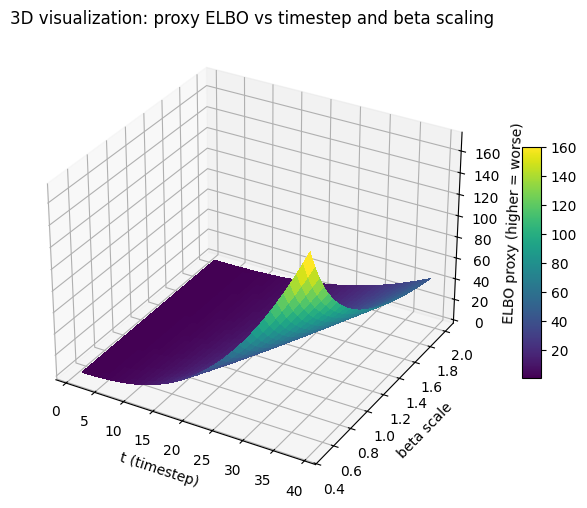

In [7]:
# Cell F — 3D surface: ELBO proxy as function of t and beta_scale
from mpl_toolkits.mplot3d import Axes3D
ts_grid = np.arange(1, min(40, T))
beta_scales = np.linspace(0.5, 2.0, 30)  # scale betas up/down to see effect
ELBO_proxy = np.zeros((len(ts_grid), len(beta_scales)))

for i,t in enumerate(ts_grid):
    for j,scale in enumerate(beta_scales):
        # scaled betas temporarily override global for this calc
        b = betas[t] * scale
        # compute alpha_bar approx locally (coarse)
        a = 1.0 - b
        ab = alpha_bar[t]  # using original for demo simplicity
        # compute posterior var approx using formula but with scaled b (toy)
        var_q = (1.0 - alpha_bar[t-1]) * b / (1.0 - alpha_bar[t])
        # take a naive mu mismatch leading to KL proportional to mean^2 / var
        # use M = mean magnitude ~ sqrt(sum x0^2) * factor depending on t
        mean_mag = np.sqrt(np.sum(x0_np**2)) * (1.0 - ab)
        kl_approx = 0.5 * (mean_mag**2) / (var_q + 1e-9)
        # plus proxy reconstruction term scaled by scale
        rec_proxy = mse_proxy * (1.0 + 0.2*(scale-1.0))
        ELBO_proxy[i,j] = kl_approx + rec_proxy

# plot 3D surface
Tg, Bg = np.meshgrid(ts_grid, beta_scales, indexing='xy')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Tg, Bg, ELBO_proxy.T, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('t (timestep)')
ax.set_ylabel('beta scale')
ax.set_zlabel('ELBO proxy (higher = worse)')
plt.title('3D visualization: proxy ELBO vs timestep and beta scaling')
fig.colorbar(surf, shrink=0.5, aspect=12)
plt.show()


In [8]:
# Cell G — Print an explicit step-by-step numeric trace for a single t
t = 10
print("Detailed trace for t =", t)
x_t, eps = q_sample_x_t(x0_np, t)
print(" - shape x0:", x0_np.shape)
print(" - sample eps (summary): mean {:.4f}, std {:.4f}".format(eps.mean(), eps.std()))
print(" - compute x_t = sqrt(alpha_bar[t])*x0 + sqrt(1-alpha_bar[t])*eps")
print("   sqrt(alpha_bar[t]) = {:.6f}, sqrt(1-alpha_bar[t]) = {:.6f}".format(
    math.sqrt(alpha_bar[t]), math.sqrt(1.0-alpha_bar[t])
))
print(" - sample x_t stats: min {:.4f}, max {:.4f}, mean {:.4f}, std {:.4f}".format(
    x_t.min(), x_t.max(), x_t.mean(), x_t.std()
))
mean_q, var_q = posterior_q_xt1_given_xt_x0_params(x_t, x0_np, t)
print(" - posterior q mean (first 5 pixels):", mean_q.flat[:5])
print(" - posterior variance (scalar):", var_q)
print(" - if p_theta predicted wrong mean mu_naive (example), KL per-pixel ~ ((mean_q-mu_naive)^2)/(2*var_naive)")


Detailed trace for t = 10
 - shape x0: (28, 28)
 - sample eps (summary): mean 0.0725, std 0.9962
 - compute x_t = sqrt(alpha_bar[t])*x0 + sqrt(1-alpha_bar[t])*eps
   sqrt(alpha_bar[t]) = 0.993936, sqrt(1-alpha_bar[t]) = 0.109958
 - sample x_t stats: min -0.3050, max 1.2785, mean 0.0997, std 0.2887
 - posterior q mean (first 5 pixels): [-0.10008423 -0.01320758 -0.12770888 -0.00215497  0.01994764]
 - posterior variance (scalar): 0.001745527345234659
 - if p_theta predicted wrong mean mu_naive (example), KL per-pixel ~ ((mean_q-mu_naive)^2)/(2*var_naive)
